<a href="https://colab.research.google.com/github/uday-routhu/week7/blob/master/Neural_Networks_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks (Core)

- author: Udayakumar Routhu

Required Task:
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance.
3. Be sure to include some form of regularization with at least one model.
Select your best model!

1. What am I predicting?
   - Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
  - predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Source of data
  The data can be downloaded from [this link](https://www.kaggle.com/competitions/nlp-getting-started/data)

### Import Libraries

In [198]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


# Set global scikit-learn configuration
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [199]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [231]:
# Load in the dataset from url
fpath = "/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week11/Data/train.csv"
df = pd.read_csv(fpath, index_col=0)
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [201]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 7613 rows, and 4 columns.
The rows represent 7613 observations, and the columns represent 3 features and 1 target variable.


## Prepare the Data

In [202]:
# Display the info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [203]:
df.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [204]:
df.dropna(inplace=True)

In [205]:
df.isna().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [206]:
# check for duplicates
df.duplicated().sum()

19

In [207]:
df = df.drop_duplicates()

In [208]:
#check for duplicates
df.duplicated().sum()

0

In [209]:
# Save X data
X = df.drop('target', axis=1)  # Features
# Encode our target
y = df['target']

In [210]:
df.head()

,keyword,location,text,target
id,,,,
48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## Train/Test Split

In [211]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [212]:
# Check class balance
y_train.value_counts(normalize=True)

0    0.566798
1    0.433202
Name: target, dtype: float64

### Transformer

In [235]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['keyword', 'location', 'text'], dtype='object')
Numeric Columns: Index([], dtype='object')


In [236]:
# process the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model 1

In [237]:
# create and compile the model
model = keras.Sequential()
model.add(Dense(10, input_dim=6636, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [238]:
# Train the model and save the history
history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
95/95 [==============================] - 2s 12ms/step - loss: 0.6827 - accuracy: 0.5672 - val_loss: 0.6798 - val_accuracy: 0.5402
Epoch 2/10
95/95 [==============================] - 1s 13ms/step - loss: 0.6248 - accuracy: 0.6505 - val_loss: 0.6258 - val_accuracy: 0.6680
Epoch 3/10
95/95 [==============================] - 1s 7ms/step - loss: 0.4650 - accuracy: 0.8501 - val_loss: 0.5664 - val_accuracy: 0.7181
Epoch 4/10
95/95 [==============================] - 0s 5ms/step - loss: 0.2846 - accuracy: 0.9282 - val_loss: 0.5603 - val_accuracy: 0.7194
Epoch 5/10
95/95 [==============================] - 0s 5ms/step - loss: 0.1553 - accuracy: 0.9723 - val_loss: 0.5761 - val_accuracy: 0.7009
Epoch 6/10
95/95 [==============================] - 0s 5ms/step - loss: 0.0825 - accuracy: 0.9901 - val_loss: 0.6038 - val_accuracy: 0.6957
Epoch 7/10
95/95 [==============================] - 0s 5ms/step - loss: 0.0473 - accuracy: 0.9957 - val_loss: 0.6207 - val_accuracy: 0.6877
Epoch 8/10
95/95 [

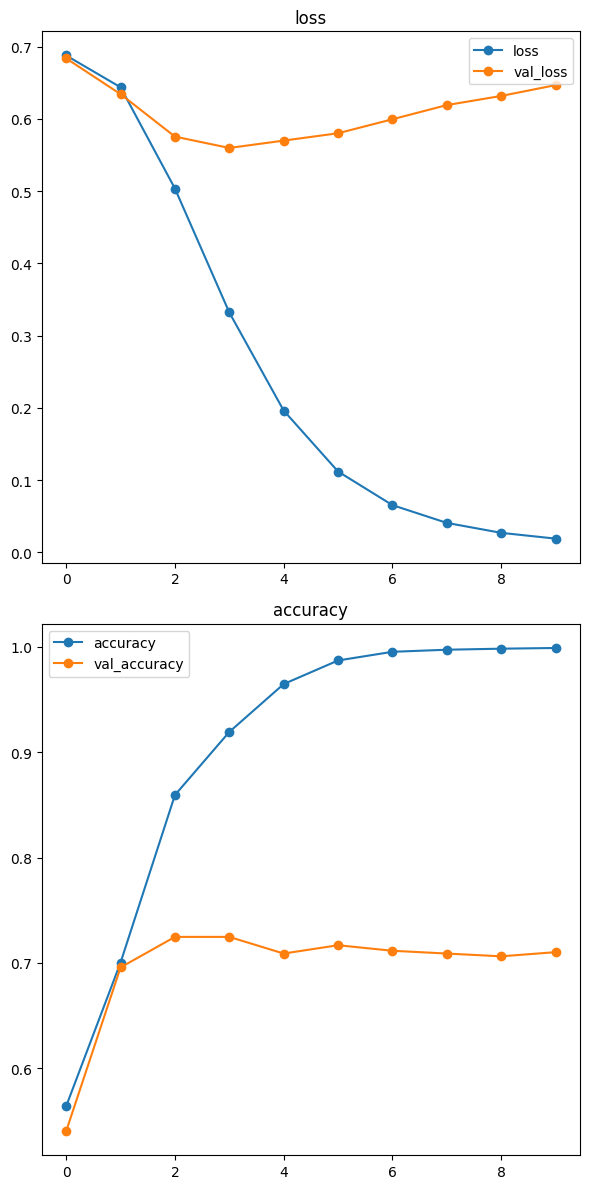

In [219]:
# Call the custom function
plot_history(history);

In [220]:
# Evaluate neural network with builtin evaluation
result = model.evaluate(X_test_processed, y_test,return_dict=True)
result

40/40 [==============================] - 0s 2ms/step - loss: 0.7308 - accuracy: 0.6509


{'loss': 0.7307828664779663, 'accuracy': 0.6508688926696777}

40/40 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       726
           1       0.58      0.63      0.61       540

    accuracy                           0.65      1266
   macro avg       0.65      0.65      0.65      1266
weighted avg       0.65      0.65      0.65      1266



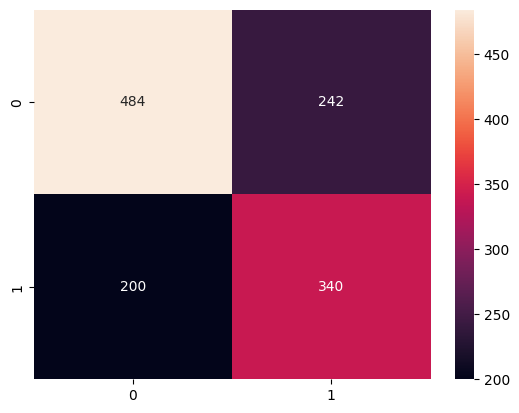

In [221]:
# evaluate the model with sklearn metrics
test_preds = model.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

1. Precision: Precision measures the proportion of true positive predictions (correctly predicted positives) out of all positive predictions. For class 0, the precision is 0.71, and for class 1, it is 0.58.

2. Recall: Recall measures the proportion of true positive predictions out of all actual positives. For class 0, the recall is 0.67, and for class 1, it is 0.63.

3. F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.69, and for class 1, it is 0.61.

4. Accuracy: The overall accuracy of your model on the test data is 0.65, which means it correctly predicts the class for 65% of the samples.


# Model 2: More Neurons

In [222]:
# create model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [223]:
# train the model and save the history
history = model2.fit(X_train_processed, y_train,
          validation_split=(.2),
          epochs = 10)

Epoch 1/10
95/95 [==============================] - 2s 8ms/step - loss: 0.6867 - accuracy: 0.5718 - val_loss: 0.6818 - val_accuracy: 0.5402
Epoch 2/10
95/95 [==============================] - 1s 6ms/step - loss: 0.6296 - accuracy: 0.6953 - val_loss: 0.6211 - val_accuracy: 0.6957
Epoch 3/10
95/95 [==============================] - 1s 6ms/step - loss: 0.4525 - accuracy: 0.8636 - val_loss: 0.5607 - val_accuracy: 0.7325
Epoch 4/10
95/95 [==============================] - 1s 6ms/step - loss: 0.2548 - accuracy: 0.9348 - val_loss: 0.5620 - val_accuracy: 0.7286
Epoch 5/10
95/95 [==============================] - 1s 6ms/step - loss: 0.1233 - accuracy: 0.9773 - val_loss: 0.5914 - val_accuracy: 0.7088
Epoch 6/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0593 - accuracy: 0.9947 - val_loss: 0.6129 - val_accuracy: 0.7036
Epoch 7/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0320 - accuracy: 0.9980 - val_loss: 0.6300 - val_accuracy: 0.7022
Epoch 8/10
95/95 [==

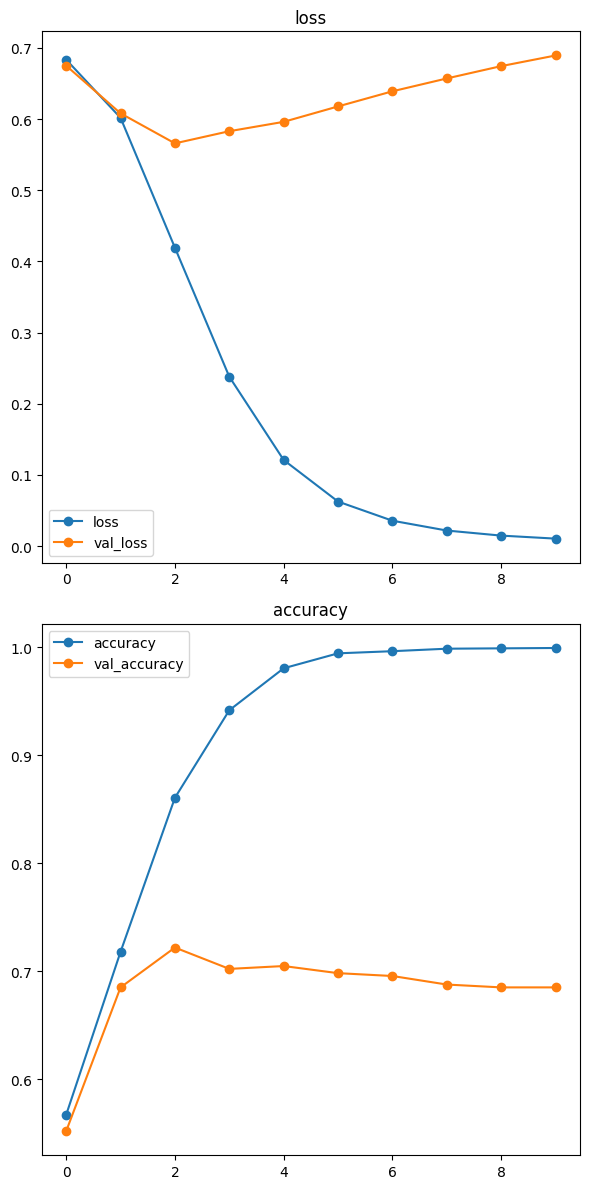

In [189]:
plot_history(history);

In [224]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_processed, y_test,return_dict=True)
result

40/40 [==============================] - 0s 3ms/step - loss: 0.7716 - accuracy: 0.6532


{'loss': 0.7716183066368103, 'accuracy': 0.6532385349273682}

40/40 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       726
           1       0.59      0.63      0.61       540

    accuracy                           0.65      1266
   macro avg       0.65      0.65      0.65      1266
weighted avg       0.66      0.65      0.65      1266



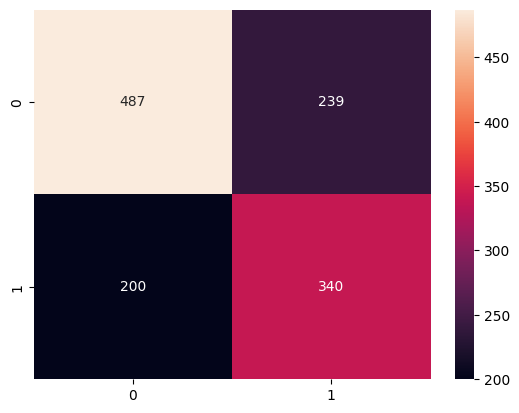

In [225]:
# evaluate the model with sklearn metrics
test_preds = model2.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt = 'g');

1. Precision: For class 0, the precision is 0.71, and for class 1, it is 0.59.

2. Recall: For class 0, the recall is 0.67, and for class 1, it is 0.63.

3. F1-Score: For class 0, the F1-score is 0.69, and for class 1, it is 0.61.

4. Accuracy: The overall accuracy of model2 on the test data is 0.65, which means it correctly predicts the class for 65% of the samples.

Comparing these metrics to the previous model (model1), it seems that model2 has similar performance in terms of precision, recall, and accuracy.

# Model 3: More layers

In [226]:
# create model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_processed.shape[1],
        activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [227]:
# train the model and save the history
history = model3.fit(X_train_processed, y_train,
          validation_split = .2,
          epochs = 10)

Epoch 1/10
95/95 [==============================] - 2s 9ms/step - loss: 0.6916 - accuracy: 0.5468 - val_loss: 0.6911 - val_accuracy: 0.5402
Epoch 2/10
95/95 [==============================] - 1s 6ms/step - loss: 0.6850 - accuracy: 0.5879 - val_loss: 0.6818 - val_accuracy: 0.6258
Epoch 3/10
95/95 [==============================] - 1s 6ms/step - loss: 0.6380 - accuracy: 0.8086 - val_loss: 0.6322 - val_accuracy: 0.7115
Epoch 4/10
95/95 [==============================] - 1s 6ms/step - loss: 0.5067 - accuracy: 0.8857 - val_loss: 0.6152 - val_accuracy: 0.6970
Epoch 5/10
95/95 [==============================] - 1s 6ms/step - loss: 0.3847 - accuracy: 0.9506 - val_loss: 0.6283 - val_accuracy: 0.6864
Epoch 6/10
95/95 [==============================] - 1s 6ms/step - loss: 0.3158 - accuracy: 0.9750 - val_loss: 0.6339 - val_accuracy: 0.6930
Epoch 7/10
95/95 [==============================] - 1s 8ms/step - loss: 0.2776 - accuracy: 0.9825 - val_loss: 0.6566 - val_accuracy: 0.6785
Epoch 8/10
95/95 [==

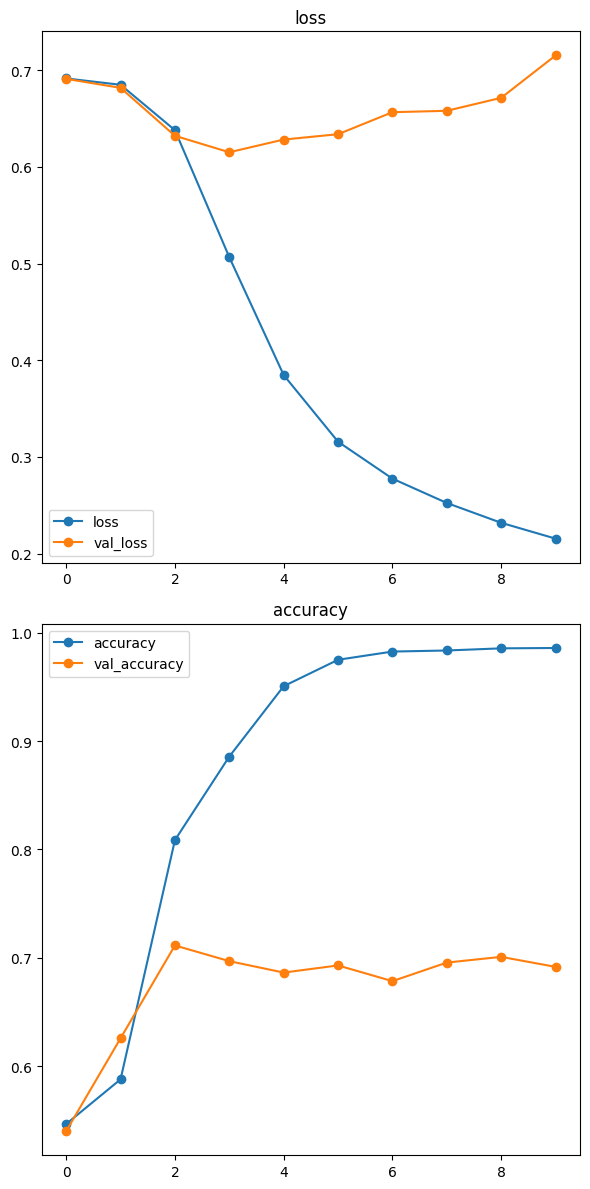

In [228]:
# Obtain history
plot_history(history);

In [229]:
# Evaluate neural network with builtin evaluation
result = model3.evaluate(X_test_processed, y_test,return_dict=True)
result

40/40 [==============================] - 0s 3ms/step - loss: 0.8271 - accuracy: 0.6430


{'loss': 0.827123761177063, 'accuracy': 0.6429699659347534}

40/40 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       726
           1       0.56      0.73      0.63       540

    accuracy                           0.64      1266
   macro avg       0.65      0.65      0.64      1266
weighted avg       0.66      0.64      0.64      1266



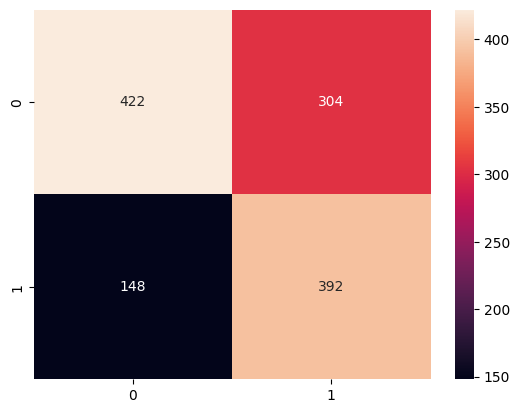

In [230]:
# evaluate the model
test_preds = model3.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

1. Precision: For class 0, the precision is 0.74, and for class 1, it is 0.56.

2. Recall: For class 0, the recall is 0.58, and for class 1, it is 0.73.

3. F1-Score: For class 0, the F1-score is 0.65, and for class 1, it is 0.63.

4. Accuracy: The overall accuracy of model3 on the test data is 0.64, which means it correctly predicts the class for 64% of the samples.

Comparing these metrics to the previous models (model1 and model2), it appears that model3 has a different trade-off between precision and recall. It has higher recall for class 1 but lower precision compared to the other models.

### choose your model

1. Model 1:

- Precision for class 0: 0.71
- Recall for class 0: 0.67
- Precision for class 1: 0.58
- Recall for class 1: 0.63
- Accuracy: 0.65

2. Model 2:

- Precision for class 0: 0.71
- Recall for class 0: 0.67
- Precision for class 1: 0.59
- Recall for class 1: 0.63
- Accuracy: 0.65

3. Model 3:

- Precision for class 0: 0.74
- Recall for class 0: 0.58
- Precision for class 1: 0.56
- Recall for class 1: 0.73
- Accuracy: 0.64


If we prioritize precision for class 0 and are willing to accept lower recall, we might prefer Model 1.

If we want a more balanced trade-off between precision and recall, we might choose Model 2, which has similar performance to Model 1 but with slightly lower precision for class 0.

If we prioritize recall for class 1 and are willing to accept lower precision, we might opt for Model 3.